<a href="https://colab.research.google.com/github/sallyMo14/Prediction-of-Diabetes/blob/main/Prediction_of_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### imports

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler ,OrdinalEncoder
from sklearn.impute import SimpleImputer,KNNImputer
# Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
# set pandas to display more columns
pd.set_option('display.max_columns',50)


In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

####EDA

In [ ]:
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

# Add **kwargs as keyword when defining function
# Include **kwargs in the sns.regplot() within the function

def plot_numeric_vs_target(df, x, y='SalePrice', figsize=(6,4), **kwargs): # kwargs for sns.regplot
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','linewidths':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax

  # Add **kwargs as keyword when defining function
# Include **kwargs in the sns.regplot() within the function



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

####Import the data

In [ ]:
file_path="/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/02-IntroML/Week08/Data/Belt2_B_diabetes_v2_final.csv"
df=pd.read_csv(file_path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,WeightGroup,AgeGroup,Gender,Outcome
0,4,189.0,110.0,31.0,NaN,0_68,overweight,18 - 44,F,0
1,2,157.0,74.0,35.0,440.0,0.134,obese_2,18 - 44,F,0
2,6,98.0,58.0,33.0,190.0,0.43,obese_1,18 - 44,F,0
3,6,111.0,64.0,39.0,NaN,0.26,obese_1,18 - 44,F,0
4,3,106.0,72.0,NaN,NaN,0_207,overweight,18 - 44,F,0


---
####Check columns data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               642 non-null    int64  
 1   Glucose                   638 non-null    float64
 2   BloodPressure             616 non-null    float64
 3   SkinThickness             455 non-null    float64
 4   Insulin                   331 non-null    float64
 5   DiabetesPedigreeFunction  642 non-null    object 
 6   WeightGroup               642 non-null    object 
 7   AgeGroup                  642 non-null    object 
 8   Gender                    642 non-null    object 
 9   Outcome                   642 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 50.3+ KB


* Some int columns have float datatypes (because they have null values)
* DiabetesPedigreeFunction  is suppose to by as Float

In [ ]:
df['DiabetesPedigreeFunction'].unique()

array(['0_68', '0.134', '0.43', '0.26', '0_207', '0.304',
       '0.19699999999999998', '0.878', '0.294', '0_261', '0.813', '0.612',
       '0.151', '0.341', '0_34700000000000003', '0_605',
       '0.7609999999999999', '0.37799999999999995', '0.303', '0.88',
       '0.14300000000000002', '0.46399999999999997', '0.527', '1.022',
       '0.33399999999999996', '0.188', '0.204', '0.389', '0.631',
       '0.5720000000000001', '0.318', '0.349', '0.258', '0.917', '0.1',
       '0.121', '0.192', '0.381', '0.292', '0.586', '0.161', '0.426',
       '0.44299999999999995', '0.263', '0_483', '0.256', '0.128',
       '0.42200000000000004', '0.235', '0.17', '0.595',
       '0.14400000000000002', '0.698', '0.39899999999999997', '0.295',
       '0.546', '0.41600000000000004', '0.23800000000000002',
       '0.36200000000000004', '0.41100000000000003', '0.085', '0.159',
       '0.156', '0.28600000000000003', '0.439', '0.4', '0.313', '0.299',
       '0.13699999999999998', '0.696', '0.433', '0.262', '0.13'

* Some cells in DiabetesPedigreeFunction Column have (_) charecter , we must replace it with (.)

In [ ]:
df['DiabetesPedigreeFunction']=df['DiabetesPedigreeFunction'].str.replace('_','.')


In [ ]:
df['DiabetesPedigreeFunction']=df['DiabetesPedigreeFunction'].astype(float)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               642 non-null    int64  
 1   Glucose                   638 non-null    float64
 2   BloodPressure             616 non-null    float64
 3   SkinThickness             455 non-null    float64
 4   Insulin                   331 non-null    float64
 5   DiabetesPedigreeFunction  642 non-null    float64
 6   WeightGroup               642 non-null    object 
 7   AgeGroup                  642 non-null    object 
 8   Gender                    642 non-null    object 
 9   Outcome                   642 non-null    int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 50.3+ KB


---
####Check for duplicates

In [ ]:
df.duplicated().sum()

np.int64(3)

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

---
####Check for null values

In [ ]:
df.isna().sum()

,0
Pregnancies,0
Glucose,4
BloodPressure,26
SkinThickness,185
Insulin,309
DiabetesPedigreeFunction,0
WeightGroup,0
AgeGroup,0
Gender,0
Outcome,0


In [ ]:
null_Glucose_filter=df['Glucose'].isna()
df[null_Glucose_filter]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,WeightGroup,AgeGroup,Gender,Outcome
28,1,NaN,68.0,35.0,NaN,0.389,obese_1,18 - 44,F,0
80,1,NaN,48.0,20.0,NaN,0.140,healthy weight,18 - 44,F,0
584,6,NaN,68.0,41.0,NaN,0.727,obese_2,18 - 44,F,1
608,5,NaN,80.0,32.0,NaN,0.346,obsese_3,18 - 44,F,1


* The Glucose null values are for females , 18-44 years old

In [ ]:
null_BloodPressure_filter=df['BloodPressure'].isna()
df[null_BloodPressure_filter]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,WeightGroup,AgeGroup,Gender,Outcome
82,2,129.0,NaN,NaN,NaN,0.304,obese_2,18 - 44,F,0
94,0,117.0,NaN,NaN,NaN,0.932,obese_1,18 - 44,M,0
149,10,115.0,NaN,NaN,NaN,0.134,obese_2,18 - 44,F,0
212,0,73.0,NaN,NaN,NaN,0.342,healthy weight,18 - 44,M,0
220,7,119.0,NaN,NaN,NaN,0.209,overweight,18 - 44,F,0
253,0,99.0,NaN,NaN,NaN,0.253,overweight,18 - 44,m,0
260,3,80.0,NaN,NaN,NaN,0.174,MISSING,18 - 44,F,0
314,2,99.0,NaN,NaN,NaN,0.108,healthy weight,18 - 44,F,0
342,2,87.0,NaN,23.0,NaN,0.773,overweight,18 - 44,F,0
354,2,84.0,NaN,NaN,NaN,0.304,MISSING,18 - 44,F,0


* There is so many null values ,and they are all from numerical columns
* I used knn imputers because I think there is a meaning correlation between the features , and the percintage of null values is moderate to use knnimputer
* knn imputer : [source 1](https://scikit-learn.org/stable/modules/impute.html) [source2](https://medium.com/@piyushkashyap045/handling-missing-values-in-data-a-beginner-guide-to-knn-imputation-30d37cc7a5b7) [source3](https://medium.com/@tarangds/knn-imputation-the-complete-guide-146f932870a7)

In [ ]:
num_imputer=KNNImputer(n_neighbors=6)
num_cols=df.select_dtypes(include="number").columns
temp_col_transformer=ColumnTransformer([("numeric",num_imputer,num_cols)],verbose_feature_names_out=False,remainder='passthrough')
temp_col_transformer.set_output(transform="pandas")
temp_col_transformer.fit_transform(df)
df_tf=temp_col_transformer.transform(df)
df_tf.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
DiabetesPedigreeFunction,0
Outcome,0
WeightGroup,0
AgeGroup,0
Gender,0


---
####Check fo inconcestency

In [ ]:
cat_cols=df_tf.select_dtypes(include='object').columns
cat_cols

Index(['WeightGroup', 'AgeGroup', 'Gender'], dtype='object')

In [ ]:
for col in cat_cols:
  print(df_tf[col].value_counts())
  print('------------------------------------------')

WeightGroup
obese_1           195
overweight        146
obese_2           126
obsese_3           86
healthy weight     74
MISSING             8
underweight         4
Name: count, dtype: int64
------------------------------------------
AgeGroup
18 - 44    526
45 - 64    102
>65          8
<65          3
Name: count, dtype: int64
------------------------------------------
Gender
F    563
M     59
m     17
Name: count, dtype: int64
------------------------------------------


* Geender column : m , M -> replace m with M
* Age column : <65 ,  It is probably a typo
* Weight_group column : obsese_3

In [ ]:
df_tf['Gender']=df_tf['Gender'].str.replace('m','M')
df_tf['Gender'].value_counts()

,count
Gender,
F,563
M,76


In [ ]:
df_tf['AgeGroup']=df_tf['AgeGroup'].replace('<65','>65')
df_tf['AgeGroup'].value_counts()

,count
AgeGroup,
18 - 44,526
45 - 64,102
>65,11


In [ ]:
df_tf['WeightGroup']=df_tf['WeightGroup'].replace('obsese_3','obese_3')
df_tf['WeightGroup'].value_counts()

,count
WeightGroup,
obese_1,195
overweight,146
obese_2,126
obese_3,86
healthy weight,74
MISSING,8
underweight,4


---
####check for impossible values

In [ ]:
df_tf.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,Outcome
count,639.000000,639.000000,639.000000,639.000000,639.000000,639.000000,639.000000
mean,5.464789,123.921231,72.388628,29.684924,156.763954,0.472022,0.419405
std,39.551779,30.658763,12.054582,9.266866,95.125269,0.325357,0.493848
min,0.000000,56.000000,24.000000,7.000000,14.000000,0.085000,0.000000
25%,1.000000,100.000000,64.000000,24.000000,94.000000,0.246500,0.000000
50%,3.000000,120.000000,72.000000,30.000000,140.000000,0.378000,0.000000
75%,6.000000,143.500000,80.000000,35.000000,194.000000,0.628000,1.000000
max,1000.000000,199.000000,114.000000,99.000000,846.000000,2.420000,1.000000


* max pregnencies =1000 is not realistic


In [ ]:
max_preg_filter=df_tf['Pregnancies']==1000
df_tf[max_preg_filter]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,Outcome,WeightGroup,AgeGroup,Gender
371,1000.0,163.0,72.0,41.0,114.0,0.817,1.0,obese_3,45 - 64,F


In [ ]:
df_tf.drop(df_tf[max_preg_filter].index,inplace=True)

In [ ]:
df_tf.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,Outcome
count,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000
mean,3.905956,123.859979,72.389237,29.667189,156.830982,0.471481,0.418495
std,3.408448,30.643665,12.064030,9.263277,95.184804,0.325324,0.493699
min,0.000000,56.000000,24.000000,7.000000,14.000000,0.085000,0.000000
25%,1.000000,100.000000,64.000000,24.000000,94.000000,0.246250,0.000000
50%,3.000000,120.000000,72.000000,30.000000,140.916667,0.377000,0.000000
75%,6.000000,143.000000,80.000000,35.000000,194.000000,0.626750,1.000000
max,15.000000,199.000000,114.000000,99.000000,846.000000,2.420000,1.000000


In [ ]:
df_tf.groupby('Gender')['Pregnancies'].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,562.0,4.434164,3.29318,0.0,2.0,4.0,7.0,15.0
M,76.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0


---
####Explore data

* Pieplot : [source](https://www.w3schools.com/python/matplotlib_pie_charts.asp)

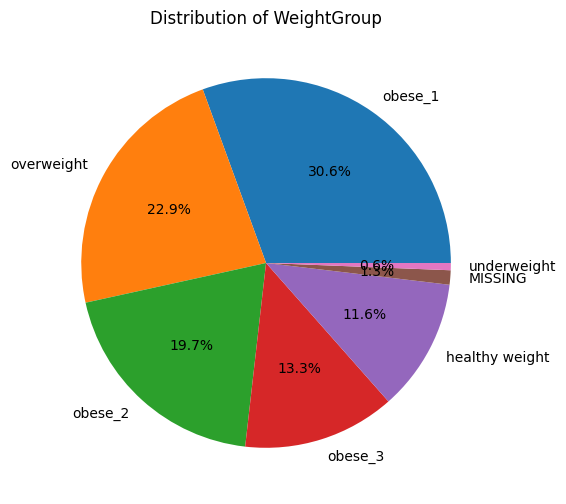

In [ ]:
WeightGroup_counts = df_tf['WeightGroup'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(WeightGroup_counts, labels=WeightGroup_counts.index, autopct='%1.1f%%')
plt.title('Distribution of WeightGroup')
plt.show()

* The plot shows that more than 30% of the records are obese_1
* more than 60% of the records suffer from obesity

/tmp/ipython-input-82-3983568200.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


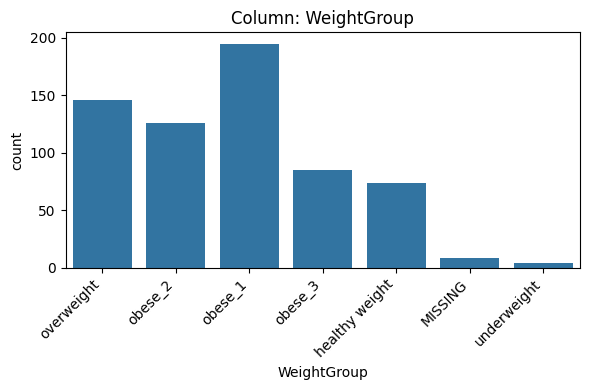

- NaN's Found: 0 (0.0%)
- Unique Values: 7
- Most common value: 'obese_1' occurs 195 times (30.56%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: WeightGroup'}, xlabel='WeightGroup', ylabel='count'>)

In [ ]:
explore_categorical(df_tf,'WeightGroup')

* The most occurence category is obese_1
* The least occurence category is underweight
* Most records have unhealthy weight condition

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * It is an ordinal feature
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * there is no null ,No need to impute.

* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * moderate (7)
* Would we know this BEFORE the target is determined?
  * Yes.
* Is there a business case/understanding reason to exclude based on our business case?
  * No

/tmp/ipython-input-82-3983568200.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


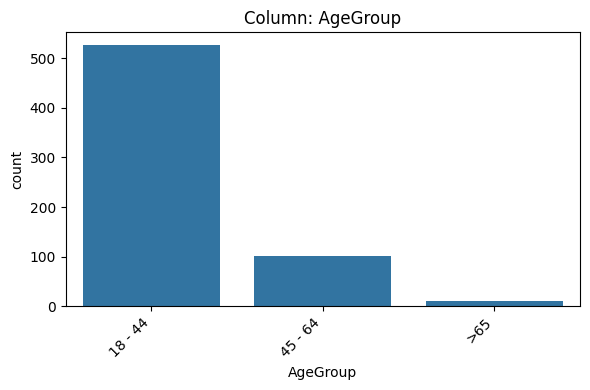

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: '18 - 44' occurs 526 times (82.45%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: AgeGroup'}, xlabel='AgeGroup', ylabel='count'>)

In [ ]:
explore_categorical(df_tf,'AgeGroup')

* Most the record are 18-44 years old

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * It is an ordinal feature
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * there is no null ,No need to impute.

* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * moderate (7)
* Would we know this BEFORE the target is determined?
  * Yes.
* Is there a business case/understanding reason to exclude based on our business case?
  * No

In [ ]:
num_cols

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'DiabetesPedigreeFunction', 'Outcome'],
      dtype='object')

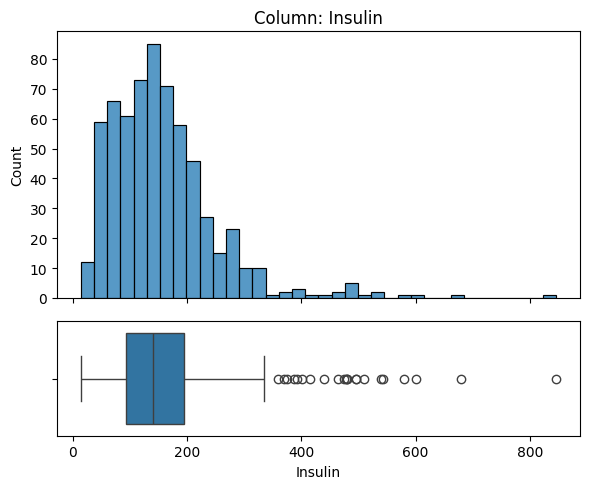

- NaN's Found: 0 (0.0%)


In [ ]:
explore_numeric(df_tf,'Insulin')

* the plot is right skewed with many otliers
* the plot shows that most insulin values land between 100-200

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * It is a numerical feature
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * there is no null ,No need to impute.

* Is the feature constant or quasi-constant?
  * Not applicable
* What is the cardinality? Is it high?
  * Not applicable
* Would we know this BEFORE the target is determined?
  * Yes.
* Is there a business case/understanding reason to exclude based on our business case?
  * No

---
#### Define target and features then split the data to train ,validate and test

In [ ]:
y=df_tf['Outcome']
X=df_tf.drop('Outcome',axis=1)

* train,test,val split source : [source](https://www.analyticsvidhya.com/blog/2023/11/train-test-validation-split/)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 446
Validation size: 96
Test size: 96


---
###Preprocessing

* i used knn imputers because i think there is a meaning correlation between the features , and the percintage of null values is moderate to use knnimputer
* knn imputer : [source 1](https://scikit-learn.org/stable/modules/impute.html) [source2](https://medium.com/@piyushkashyap045/handling-missing-values-in-data-a-beginner-guide-to-knn-imputation-30d37cc7a5b7) [source3](https://medium.com/@tarangds/knn-imputation-the-complete-guide-146f932870a7)

In [ ]:
#define numerical columns
num_cols=X_train.select_dtypes(include="number").columns
#define transformers
num_scaler=StandardScaler()
num_imputer=KNNImputer(n_neighbors=6)
#define num pipe line
num_pipe=make_pipeline(num_imputer,num_scaler)
num_tuple=("numeric",num_pipe,num_cols)


In [ ]:
#define ord columns
ord_cols=['WeightGroup', 'AgeGroup']
#define transformerd
ord_imputer=SimpleImputer(strategy='constant',fill_value="MISSING")
WeightGroup_values_orderd= [ 'MISSING','underweight','healthy weight','overweight','obese_1','obese_2','obese_3']
AgeGroup_values_orderd=['18 - 44','45 - 64','>65']
ord_categories_order=[WeightGroup_values_orderd,AgeGroup_values_orderd]
ord_encoder=OrdinalEncoder(categories=ord_categories_order,)##we will use one hot encoder because it is an ordinal data(it can be ordered)
ord_scaler=StandardScaler()
#define ord pipe
ord_pipe=make_pipeline(ord_imputer,ord_encoder,ord_scaler)
ord_tuple=("ordinal",ord_pipe,ord_cols)

In [ ]:
#define cat columns
cat_cols=['Gender']
#define transformers
cat_imputer=SimpleImputer(strategy='constant',fill_value='MISSING')
cat_encoder=OneHotEncoder(sparse_output=False,handle_unknown='ignore')##we will use one hot encoder because it is a nominal data(with no order)
#define cat pipe
cat_pipe=make_pipeline(cat_imputer,cat_encoder)
cat_tuple=("categorical",cat_pipe,cat_cols)

In [ ]:
#create column transformer
col_transformer=ColumnTransformer(transformers=[num_tuple,ord_tuple,cat_tuple],remainder='passthrough',verbose_feature_names_out=False)
col_transformer.set_output(transform="pandas",)
#pipeline=make_pipeline(col_transformer,LogesticRegression())
col_transformer.fit_transform(X_train)
X_train_tf=col_transformer.fit_transform(X_train)
X_val_tf=col_transformer.transform(X_val)
X_test_tf=col_transformer.transform(X_test)

* from the generated columns of ohe feature we will drop just one column to reduce multicolonearity

In [ ]:
X_train_tf=X_train_tf.drop(columns=['Gender_M'])
X_val_tf=X_val_tf.drop(columns=['Gender_M'])
X_test_tf=X_test_tf.drop(columns=['Gender_M'])

In [ ]:
X_train_tf.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
DiabetesPedigreeFunction,0
WeightGroup,0
AgeGroup,0
Gender_F,0


---
#### Modeling


In [ ]:
#checking if the target balnced or not
y_train.value_counts(normalize=True)

,proportion
Outcome,
0.0,0.567265
1.0,0.432735


* The outcome is balanced

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       253
         1.0       1.00      1.00      1.00       193

    accuracy                           1.00       446
   macro avg       1.00      1.00      1.00       446
weighted avg       1.00      1.00      1.00       446



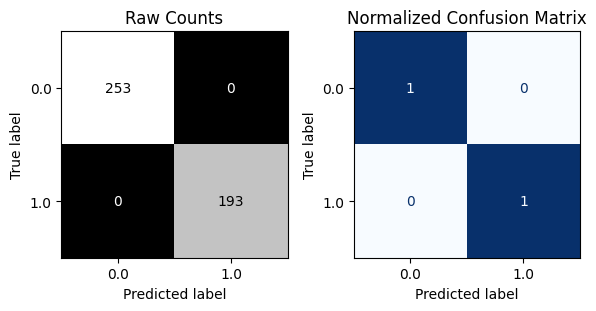


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.74      0.75      0.75        57
         1.0       0.63      0.62      0.62        39

    accuracy                           0.70        96
   macro avg       0.69      0.68      0.69        96
weighted avg       0.70      0.70      0.70        96



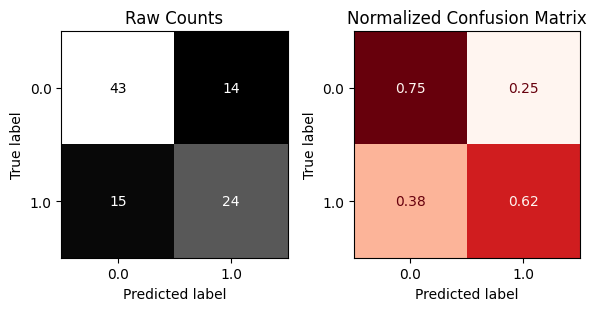

In [ ]:
#DecisionTreeClassifier Base model
from sklearn.tree import DecisionTreeClassifier
dec_tree=DecisionTreeClassifier(random_state=42)
dec_tree.fit(X_train_tf,y_train)
evaluate_classification(dec_tree,X_train_tf,y_train,X_val_tf,y_val)

* The base decision tree classification  model is overfitted to training data
* The recall for the validation set is very bad , since we are interested in predicting the most true values(class 1)

param_grid [source](https://www.geeksforgeeks.org/machine-learning/how-to-tune-a-decision-tree-in-hyperparameter-tuning/)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92       253
         1.0       0.87      0.94      0.90       193

    accuracy                           0.91       446
   macro avg       0.91      0.91      0.91       446
weighted avg       0.91      0.91      0.91       446



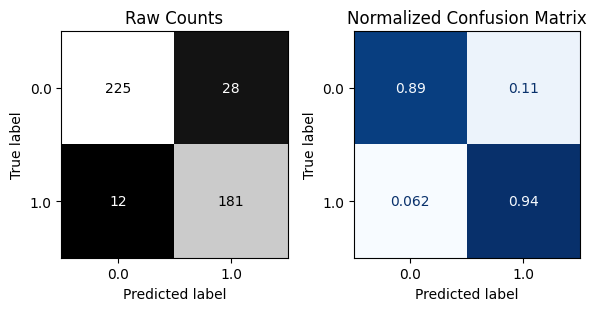


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.70      0.68      0.69        57
         1.0       0.55      0.56      0.56        39

    accuracy                           0.64        96
   macro avg       0.62      0.62      0.62        96
weighted avg       0.64      0.64      0.64        96



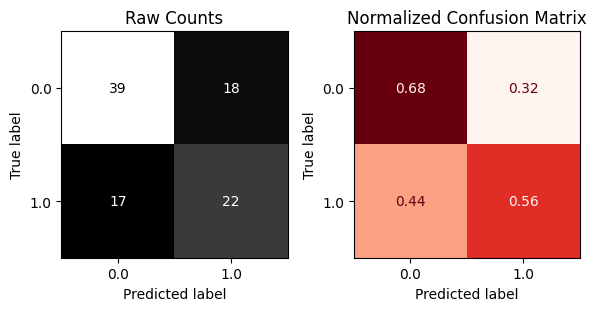

In [ ]:
#DecisionTreeClassifier Tunned model
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=dec_tree, param_grid=param_grid,cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_tf, y_train)
best_dec_tree = grid_search.best_estimator_
evaluate_classification(best_dec_tree,X_train_tf,y_train,X_val_tf,y_val)

* The model quality has significantly decreased
  * recall 0.62 -> 0.56
  * f1 scoe 0.62 -> 0.56
  * accuracy 0.70 -> 0.64

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77       253
         1.0       0.71      0.65      0.68       193

    accuracy                           0.74       446
   macro avg       0.73      0.73      0.73       446
weighted avg       0.73      0.74      0.73       446



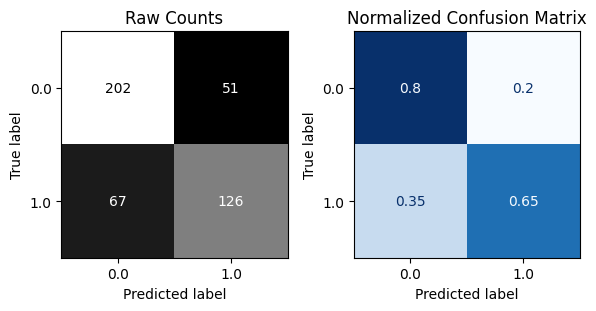


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83        57
         1.0       0.76      0.72      0.74        39

    accuracy                           0.79        96
   macro avg       0.79      0.78      0.78        96
weighted avg       0.79      0.79      0.79        96



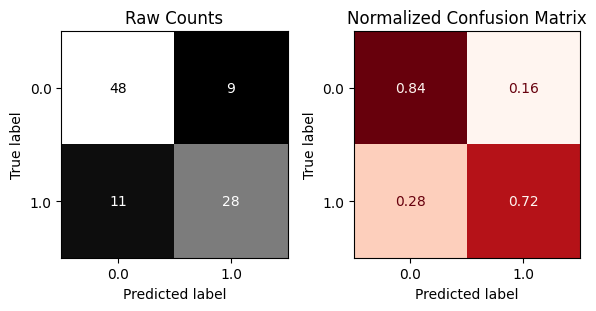

In [ ]:
#most accuracy
#most f1
#second less recall
#most macroes
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(random_state=42)
log_reg.fit(X_train_tf,y_train)
evaluate_classification(log_reg,X_train_tf,y_train,X_val_tf,y_val)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77       253
         1.0       0.71      0.64      0.68       193

    accuracy                           0.73       446
   macro avg       0.73      0.72      0.72       446
weighted avg       0.73      0.73      0.73       446



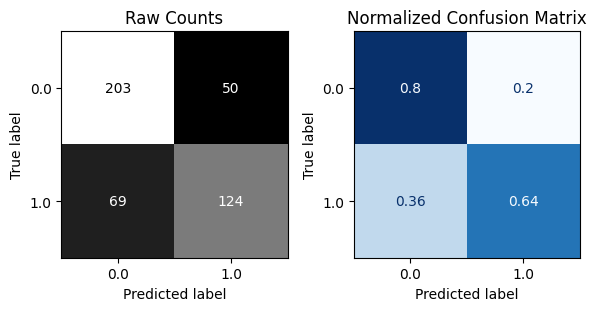


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84        57
         1.0       0.78      0.72      0.75        39

    accuracy                           0.80        96
   macro avg       0.80      0.79      0.79        96
weighted avg       0.80      0.80      0.80        96



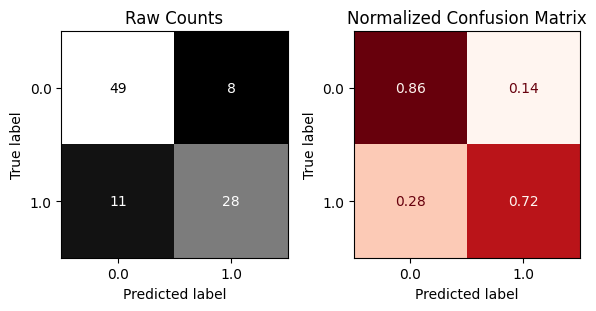

In [ ]:
param_grid = {
   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] ,
   'max_iter'  : [100,1000,2500,5000]
}
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid,cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_tf, y_train)
best_log_reg = grid_search.best_estimator_
evaluate_classification(best_log_reg,X_train_tf,y_train,X_val_tf,y_val)

* It is slightly better than the base logistic regression

####Best model

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92       253
         1.0       0.87      0.94      0.90       193

    accuracy                           0.91       446
   macro avg       0.91      0.91      0.91       446
weighted avg       0.91      0.91      0.91       446



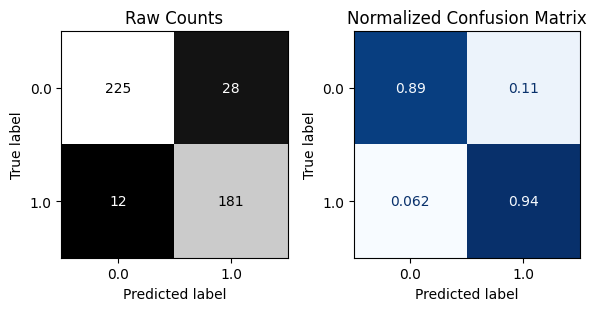


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.67      0.74        61
         1.0       0.57      0.74      0.64        35

    accuracy                           0.70        96
   macro avg       0.69      0.71      0.69        96
weighted avg       0.73      0.70      0.70        96



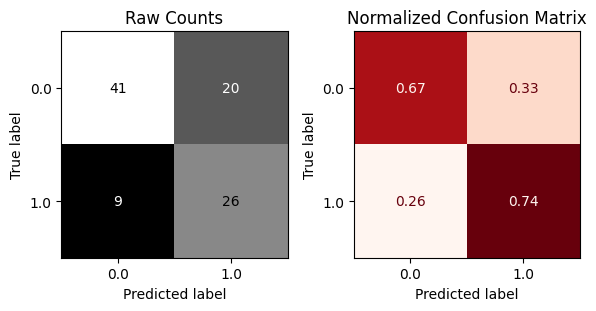

In [ ]:
evaluate_classification(best_dec_tree,X_train_tf,y_train,X_test_tf,y_test)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77       253
         1.0       0.71      0.64      0.68       193

    accuracy                           0.73       446
   macro avg       0.73      0.72      0.72       446
weighted avg       0.73      0.73      0.73       446



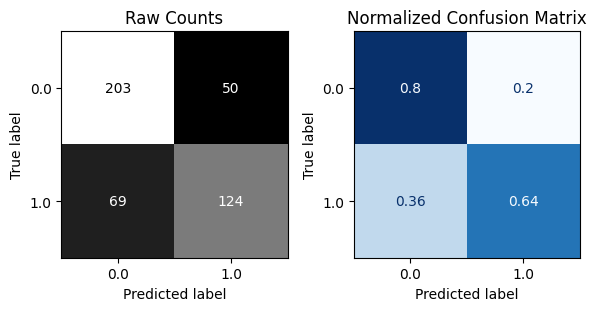


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86        61
         1.0       0.76      0.74      0.75        35

    accuracy                           0.82        96
   macro avg       0.81      0.81      0.81        96
weighted avg       0.82      0.82      0.82        96



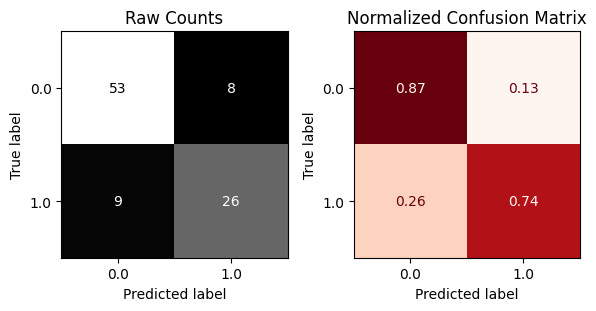

In [ ]:

evaluate_classification(best_log_reg,X_train_tf,y_train,X_test_tf,y_test)

* The tunned logesstic regression have higher f1_score ,recall and accuracy
  * so O think it is the best model

In [ ]:
best_model=best_log_reg

It is working better on the testing data also

---
####Recommendation
* Since it is a small data set ( only 640 records) We nedd more records to make the models learn more efficient and to improve models prediction
* some features must be more balanced
  * for example , in Age_group column , more than 80% of the records are 18-44 years old , and a very few from other categories in that column ( which in real life have more probability to have diabetes)
  * in addition to Gender column ,more than 80% are females